## Test



In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from pyproj import CRS, Geod
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'wrf_dir': '/home/arthur/data/tropical_cyclones/WRF/Milton/',
    'wvn_dir': '/home/arthur/data/tropical_cyclones/WIVERN/Milton/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/WIVERN/Test/',
}

PRMS = {
    'sav_fgs': False,
}

# Open data
ds_wrf = xr.open_dataset(PTHS['wrf_dir'] + 'wrfout_d02_2024-10-08_00:00:00').isel(Time=0)
ds_wvn = xr.open_dataset(PTHS['wvn_dir'] + 'wrfout_d02_2024-10-08_00-00-00_L3-winds-3D.nc')

In [3]:
#########################
### General functions ###
#########################
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

#########################
### KEPERT 2025 MODEL ###
#########################
# Inertial stability
def I(Rs, Vs, fcor):
    dr   = np.diff(Rs[0, 0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=2) + Vs / Rs + fcor
    return np.sqrt(ksi * zeta)

# Coefficients
def sqrt_alpha_beta(Rs, Vs, fcor):
    '''Corresponds to sqrt(alpha / beta).'''
    dr   = np.diff(Rs[0, 0, :])[0] # meters
    ksi  = 2 * Vs / Rs + fcor
    zeta = np.gradient(Vs, dr, axis=2) + Vs / Rs + fcor
    return np.sqrt(ksi / zeta)

def eta(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * ((Vs / Rs) + I(Rs, Vs, fcor))))

def ki(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * I(Rs, Vs, fcor)))

def psi(Rs, Vs, K, C, fcor):
    return C * Vs * np.sqrt(2 / (K * abs((Vs / Rs) - I(Rs, Vs, fcor))))

# Amplitudes
def A0(Rs, Vs, K, C, fcor):
    num = -ki(Rs, Vs, K, C, fcor) * Vs * [1 + 1j * (1 + ki(Rs, Vs, K, C, fcor))]
    den = 2 * ki(Rs, Vs, K, C, fcor) ** 2 + 3 * ki(Rs, Vs, K, C, fcor) + 2
    return num / den

def A1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(3 + 1j) * ki0 * ki_1 + (2 - 2j) * (ki0 + ki_1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki1 + 3j * ki_1]
    return num / den

def A_1(Rs, Vs, K, C, c1, c2, fcor):
    '''Note the error of parenthesis in his Eq. 29 - I re-computed the exact coefficients, the parenthesis should be removed.'''
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [(3 + 1j) * ki0 * ki1 + (2 - 2j) * (ki0 + ki1) - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [(2 + 2j) * (1 + ki1 * ki_1) + 3 * ki_1 + 3j * ki1]
    return num / den

def A1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 - 1j * c2) * ki1 * [(1 - 3j) * ki0 * ki_1 + (2 - 2j) * ki0 - (2 + 2j) * ki_1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 + 2j + 3 * (ki1 + ki_1) + (2 - 2j) * ki1 * ki_1]
    return num / den

def A_1_prime(Rs, Vs, K, C, c1, c2, fcor):
    # New notations
    ki0  = ki(Rs, Vs, K, C, fcor)
    ki1  = eta(Rs, Vs, K, C, fcor)
    ki_1 = psi(Rs, Vs, K, C, fcor)
    # New expressions
    num  = (c1 + 1j * c2) * ki_1 * [1j * (1 - 3j) * ki0 * ki1 + (2 - 2j) * ki0 + (2 + 2j) * ki1 - 4j] * abs(Vs)
    den  = 2 * (2 * ki0 ** 2 + 3 * ki0 + 2) * [2 - 2j + 3 * (ki1 + ki_1) + (2 + 2j) * ki1 * ki_1]
    return num / den

# Thicknesses
def delta0(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor)))

def delta1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) + Vs / Rs))

def delta_1(Rs, Vs, K, fcor):
    return np.sqrt(2 * K / abs(I(Rs, Vs, fcor) - Vs / Rs))

# Radial and tangential wind components
def u0(Rs, Vs, K, C, fcor, zi, z_ref):
    u0 = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(u0,  np.shape(u0)[1:])

def v0(Rs, Vs, K, C, fcor, zi, z_ref):
    v0 = np.imag(A0(Rs, Vs, K, C, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta0(Rs, Vs, K, fcor)))
    return np.reshape(v0,  np.shape(v0)[1:])

def u1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    otherwise = np.imag(A1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 + 1j) * (zi - z_ref) / delta1(Rs, Vs, K, fcor) + 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

def u_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    u1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = sqrt_alpha_beta(Rs, Vs, fcor) * np.real(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    u1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    u1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return u1

def v_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    v1        = Vs * 0
    msk       = I(Rs, Vs, fcor) >= Vs / Rs
    if_msked  = np.imag(A_1(Rs, Vs, K, C, c1, c2, fcor)       * np.exp(- (1 + 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    otherwise = np.imag(A_1_prime(Rs, Vs, K, C, c1, c2, fcor) * np.exp(- (1 - 1j) * (zi - z_ref) / delta_1(Rs, Vs, K, fcor) - 1j * h * THs))
    v1[msk]   = np.reshape(if_msked,  np.shape(if_msked)[1:])[msk]
    v1[~msk]  = np.reshape(otherwise, np.shape(if_msked)[1:])[~msk]
    return v1

# TOTAL WIND COMPONENTS IN THE BL
def u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # print(np.shape(THs), np.shape(zi), np.shape(z_ref))
    # Vs_dyd = np.concatenate((np.stack([np.ones(np.argmax(Vs)) for i in range(np.shape(Vs)[0])]) * Vs[0, 0], Vs), axis=1)[:, :np.shape(Vs)[1]]
    # return u_1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h) + u0(Rs, Vs, K, C, fcor, zi, z_ref) + u1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h)
    return u_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h) + u0(Rs, Vs, K, C, fcor, zi, z_ref) + u1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)

def v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # Vs_dyd = np.concatenate((np.stack([np.ones(np.argmax(Vs)) for i in range(np.shape(Vs)[0])]) * Vs[0, 0], Vs), axis=1)[:, :np.shape(Vs)[1]]
    # return Vs + v_1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h) + v0(Rs, Vs, K, C, fcor, zi, z_ref) + v1(THs, Rs, Vs_dyd, K, C, c1, c2, fcor, zi, z_ref, h)
    return Vs + v_1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h) + v0(Rs, Vs, K, C, fcor, zi, z_ref) + v1(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)

# FINAL MODEL
def kepert2025(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h):
    # Returns Kepert wind speeds
    u_K25   = u_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)
    v_K25   = v_BL(THs, Rs, Vs, K, C, c1, c2, fcor, zi, z_ref, h)  

    # Not for K25!!!
    # # Adds the translation speed
    # Utu     = Ut * np.cos(THs) # Radial component of Ut
    # Utv     = -Ut * np.sin(THs) # Tangential component of Ut
    # # Utu = Utv = 0
    
    # return u_K25 + Utu, v_K25 + Utv
    return u_K25, v_K25

#########################
### CREATE STRUCTURES ###
#########################
def get_xrDataset_polar(zs, ths, rs, u_K25, v_K25):
    kep_pol = xr.Dataset(
        data_vars={
            'wind_speed': (('z', 'theta', 'rad'), np.sqrt(np.array(v_K25) ** 2 + np.array(u_K25) ** 2)),
            'rad_wind':   (('z', 'theta', 'rad'), np.array(u_K25)),
            'tan_wind':   (('z', 'theta', 'rad'), np.array(v_K25)),
        },
        coords={
            'z': zs,
            'theta': np.rad2deg(ths),
            'rad': rs,
        }
    )
    kep_pol['inflow_angle'] = np.rad2deg(np.arctan((kep_pol.rad_wind / kep_pol.tan_wind))) # Inflow Angle Polar
    return kep_pol

def get_xrDataset_cartesian(Xs, Ys, x_ref, y_ref, dim_ref, kep_pol):
    KEP_CARS = []
    for z in tqdm(zs): # Takes ~20 seconds
        kep_car = xr.Dataset(
            data_vars={
                'wind_speed':   (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
                'rad_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'tan_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
                'inflow_angle': (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
            },
            coords={
                'x': dim_ref,
                'y': dim_ref,
            }
        )
        KEP_CARS.append(kep_car)
    kep_car = xr.concat(KEP_CARS, 'z').assign_coords({'z': zs})
    return kep_car

### Get vertical velocity estimates
# For the expression see e.g Ueno and Kunii 2009
def get_w(kep_pol, kep_car, zs):
    # Compute vertical velocity by integrating continuity equation
    dru_dr = (kep_pol.rad * kep_pol.rad_wind).differentiate('rad') # d(ru)/dr
    dv_dth = kep_pol.tan_wind.differentiate('theta') / (2 * np.pi / 360) # dv/dtheta, dtheta converted in radians here
    # dv_dth = kep_pol.tan_wind.differentiate('theta')               # dv/dtheta
    WS_POL = []
    WS_CAR = []
    for z in tqdm(zs):
        integral = (dru_dr + dv_dth).sel(z=slice(None, z)).integrate('z')
        w_pol    = - (1 / integral.rad) * integral
        WS_POL.append(w_pol)
        w_car = griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(w_pol.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        WS_CAR.append(xr.DataArray(w_car, coords={'x': dim_ref,'y': dim_ref}))
    kep_pol['w'] = xr.concat(WS_POL, dim='z')
    kep_car['w'] = xr.concat(WS_CAR, dim='z')
    return kep_pol, kep_car

#########################
###   MODEL FITTING   ###
#########################
def wind_reduction_factor(Rs, Vs, K, C, fcor):
    '''wrf = surface azim. wind / gradient azim. wind'''
    ki_cst  = ki(Rs, Vs, K, C, fcor)
    num     = ki_cst ** 2 + 2 * ki_cst + 2
    den     = 2 * ki_cst ** 2 + 3 * ki_cst + 2
    return num / den

def wn1(thetas, a, phi, c):
    return a * np.cos(thetas + phi) + c

def get_wn1(thetas, wind_speed, initial_condition=15, upper_bound=80):
    '''
    initial_condition: initial conidition for the amplitude and the constant c (just put Vplus)
    upper_bound: upper bound for the the amplitude and the constant c (just put Vmax)
    '''
    # Fitting process
    popt, pcov = curve_fit(
        f=wn1,
        xdata=thetas,
        ydata=wind_speed,
        p0=[initial_condition, np.pi / 2, initial_condition],
        bounds=([1., -2 * np.pi, 0.1], [upper_bound, 2 * np.pi, upper_bound]) # ([lower bounds], [upper bounds])
    )
    a, phi, c = popt[0], popt[1], popt[2]
    return a, phi, c

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#########################
###       PLOT        ###
#########################
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  = 0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

palette = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd         = getColorMap(rgbFile=palette)
normalizer   = Normalize(0, 80)

In [4]:
### FUNCTIONS TO COMPUTE ASYMMETRY AMPLITUDE
### FITS HOLLAND AT EACH RADIUS

def initialize_radius(spdm):
    '''Given the spdm, returns the largest radius (and asociated spdm) on which the profile can be fitted. 
    Indeed, sometimes the spdm isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(spdm)
    r                 = np.arange(last_valid_index) # to avoid having both r = 0 and n < 0 during fitting process
    
    ### Lower bound
    # We change it if spdm[0] = nan
    if np.isnan(spdm[0]):
        first_valid_index = np.min(np.where(np.isfinite(spdm)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.isnan(np.min(spdm[first_valid_index:])):
        last_valid_index  = np.min(np.where(np.isnan(spdm[first_valid_index:]))[0]) # returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
    # Define r and spdm
    r    = r[first_valid_index:last_valid_index] * 1000
    spdm = spdm[first_valid_index:last_valid_index]
    
    return r, spdm

# Test - Compute asymmetry by computing an average Holland per theta slice to smooth all the noise
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

# Define the steps
# TODO: I could refine how I choose these steps to make them more continuous
# th_steps = np.linspace(0, 340, 341)
th_steps = np.linspace(0, 360, 19)[:-1] # Slice of 20 degrees
th_delta = 20 # degrees

In [5]:
def get_rmse_wrt_sar_fixedK(optim_params, K, THs_sar, Rs_sar, Zs_sar, ths, rs, zs_sar, Vs_sar, fcr, z_ref, h, dsp_sar):
    # Extraire les paramètres à optimiser
    C, c1, c2 = optim_params

    # Wind at gradient level
    wrf        = wind_reduction_factor(Rs_sar, Vs_sar, K, C, fcr) # azimuthal wind
    Vs_try_sar = Vs_sar / wrf

    # Get K25
    u_K25, v_K25 = kepert2025(THs_sar, Rs_sar, Vs_try_sar, K, C, c1, c2, fcr, Zs_sar, z_ref, h)

    # Get polar dataset
    kep_pol      = get_xrDataset_polar(zs_sar, ths, rs, u_K25, v_K25)

    return float(rmse(kep_pol.interp(coords={'rad': np.array(dsp_sar.wind_speed.transpose().rad)}).sel(theta=slice(0, 359)).wind_speed, dsp_sar.wind_speed.transpose()))

In [6]:
r_ref         = np.linspace(0, 500, int((500 // 1) + 1))
t_ref         = np.linspace(0, 360, 361)
dim_ref       = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000

### FUNCTIONS
def get_polar_theta(forward_az):
    '''INPUT: forward_az: 0° is North, 90° is East;
    OUTPUT: theta: 0° is East, 90° is North'''
    theta = (90 - forward_az) % 360 # 0° is North, 90° is East
    return theta

In [7]:
def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

# Bounds for fitting
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

#### 1) Define center

In [8]:
lon_cen = -90.07
lat_cen = 22.51

plt.pcolormesh(ds_wrf.XLONG, ds_wrf.XLAT, np.sqrt(ds_wrf.U10 ** 2 + ds_wrf.V10 ** 2), cmap=cwnd, norm=normalizer)
plt.ylim(20, 26)
plt.xlim(-93, -87)
plt.grid()
plt.colorbar(label='Wind speed (m/s)', orientation='vertical', pad=0.05, extend='neither')
plt.scatter(lon_cen, lat_cen, marker='x', c='w', s=50, linewidths=2)
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

# plt.savefig(PTHS['sav_dir'] + 'ws_WRF_srfc.png', bbox_inches='tight', format='png');plt.clf()

/tmp/ipykernel_23600/2516286995.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(ds_wrf.XLONG, ds_wrf.XLAT, np.sqrt(ds_wrf.U10 ** 2 + ds_wrf.V10 ** 2), cmap=cwnd, norm=normalizer)


<Figure size 1500x1000 with 0 Axes>

#### 2) Convert WRF to polar/cartesian coordinates

In [9]:
### ==> Convert to polar
# Create lon and lat grids
lons        = np.array(ds_wrf.XLONG)
lats        = np.array(ds_wrf.XLAT)

# Create center grids
lons_center = np.ones_like(lons) * lon_cen
lats_center = np.ones_like(lats) * lat_cen

# Compute azimuth and distance from center for each (lon, lat) pair
geod_wgs84        = CRS("epsg:4326").get_geod()
forward_az, _, dr = geod_wgs84.inv(lons_center, lats_center, lons, lats)
th                = get_polar_theta(forward_az) # r is dr

# Ref. grid
r_grd, t_grd = np.meshgrid(r_ref, t_ref)

# Interpolate on reference grid
ws_pol       = griddata((dr.flatten() / 1000, th.flatten()), np.array(np.sqrt(ds_wrf.U10 ** 2 + ds_wrf.V10 ** 2)).flatten(), (r_grd, t_grd), method='linear')

# Create xr.Dataset
ds_pol = xr.Dataset(
    data_vars={
        'wind_speed':      (['theta', 'rad'], ws_pol),
        'lat_cen':         ([], lat_cen),
        'lon_cen':         ([], lon_cen),
    },
    coords={
        'theta': t_ref,
        'rad':   r_ref * 1000
    }
)

### ==> Convert to cartesian
ds_x, ds_y = pol2cart(dr, np.deg2rad(th))

# Ref. grid
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)

# Interpolate on reference grid
ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(np.sqrt(ds_wrf.U10 ** 2 + ds_wrf.V10 ** 2)).flatten(), (x_ref, y_ref), method='linear')

#  Create Dataset
ds_car = xr.Dataset(
    data_vars={
        'wind_speed':      (['x', 'y'], ws_car), 
        'lat_cen':         ([], lat_cen),
        'lon_cen':         ([], lon_cen),
    },
    coords={
        'x': dim_ref,
        'y': dim_ref
    }
)

#### 3) Fit Holland

In [10]:
wsm = ds_pol.wind_speed.mean(dim='theta', skipna=True).isel(rad=slice(1, None))

In [11]:
# Holland
popt, pcov = curve_fit(
    lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, lat_cen, B, Vmin, Rmax, Vmax), 
    np.array(np.array(wsm.rad)), 
    np.array(np.array(wsm)), 
    p0=[1.8, 5, 20 * 1000, 40], 
    bounds=(
        tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
        tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
    ) 
) 
B_hol, vmn_hol, rmx_hol, vmx_hol = popt

Text(0, 0.5, 'Wind speed (m/s)')

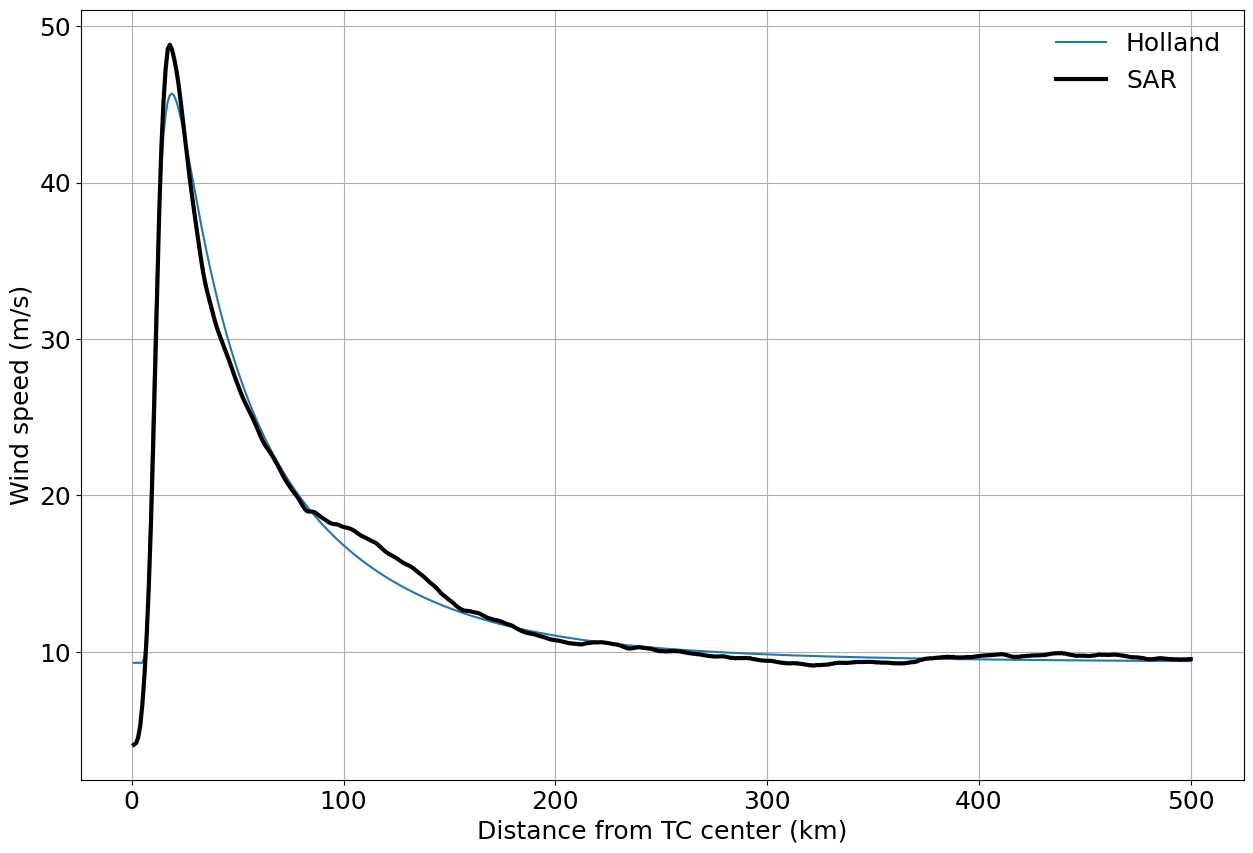

In [12]:
plt.plot(wsm.rad / 1000, holland_profile(wsm.rad, lat_cen, B_hol, vmn_hol, rmx_hol, vmx_hol), c='tab:blue', label='Holland')
plt.plot(wsm.rad / 1000, wsm, c='k', linewidth=3, label='SAR')
plt.legend(frameon=False)
plt.grid()
plt.xlabel('Distance from TC center (km)')
plt.ylabel('Wind speed (m/s)')

#### 4) Fit K25

In [13]:
#########################
###  HYPERPARAMETERS  ###
#########################
### Reference grids
# Low-resolution grids - To speed up fitting
rs            = np.linspace(1000, 5e5, 500)
ths           = np.linspace(0, 2 * np.pi, 181)                           # in radians
zs            = np.array([10])
Rs, THs       = np.meshgrid(rs, ths)                                     # shape (361, 5000)

# Vectorize on dim z
THs           = np.repeat(np.expand_dims(THs, axis=0), len(zs),  axis=0) # shape e.g (len(zs), 361, 5000)
Rs            = np.repeat(np.expand_dims(Rs,  axis=0), len(zs),  axis=0) # shape e.g (len(zs), 361, 5000)
Zs            = np.repeat(np.expand_dims(zs,  axis=1), len(ths), axis=1) # shape e.g (len(zs), 361, 5000)
Zs            = np.repeat(np.expand_dims(Zs,  axis=2), len(rs),  axis=2) # shape e.g (len(zs), 361, 5000)

# To create cartesian dataset
Xs, Ys        = pol2cart(Rs, THs)                                        # to create cartesian dataset
dim_ref       = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000   # to create cartesian dataset
x_ref, y_ref  = np.meshgrid(dim_ref, dim_ref)                            # to create cartesian dataset

# To compute asymmetries
xs            = np.linspace(1000, 250000, 250)

# Ref. height
z_ref         = 10

# Fitting values
fixed_K       = 50
# fixed_K       = 100
# fixed_K       = 150
# fixed_K       = 200
# fixed_K       = 1
initial_guess = [1.5e-3, 0.1, 0.1] 
bounds        = [(1e-4, 1e-1), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre, K = 50
# bounds        = [(np.sqrt(2) * 1e-4, np.sqrt(2) * 1e-1), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre, K = 100
# bounds        = [(np.sqrt(3) * 1e-4, np.sqrt(3) * 1e-1), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre, K = 150
# bounds        = [(np.sqrt(4) * 1e-4, np.sqrt(4) * 1e-1), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre, K = 200
# bounds        = [(1e-4 / np.sqrt(50), 1e-1 / np.sqrt(50)), (-10., 10.), (-10., 10.)] # (min, max) pour chaque paramètre, K = 1

In [14]:
# Holland
V    = holland_profile(rs, lat_cen, B_hol, vmn_hol, rmx_hol, vmx_hol)
Vs   = np.stack([V for i in range(np.shape(THs)[1])]) # Shape (361, 5000)
Vs   = np.repeat(np.expand_dims(Vs, axis=0), len(zs), axis=0)
fcr  = coriolis(lat_cen)
h    = 1

In [15]:
# Fitting
fixed_args    = (fixed_K, THs, Rs, Zs, ths, rs, zs, Vs, fcr, z_ref, h, ds_pol)
result        = minimize(get_rmse_wrt_sar_fixedK, initial_guess, args=fixed_args, method='L-BFGS-B', bounds=bounds) # Takes less than 30 seconds

# Extract result
if result.success:
    C_opt, c1_opt, c2_opt = result.x
    print("Optimisation réussie !")
    print(f"K initial : {fixed_K:.0f}")
    print(f"C optimisé : {C_opt:.5f}")
    print(f"c1 optimisé : {c1_opt:.4f}")
    print(f"c2 optimisé : {c2_opt:.4f}")
    print(f"RMSE final : {result.fun:.4f}")
    print(f"c1 / c2 : {c1_opt / c2_opt:.4f}")
    print(f"C / sqrt(K) : {C_opt / np.sqrt(fixed_K):.6f}")
else:
    print('Optimisation failed for t = {}'.format(t))
    print(result.message)
    C_opt = c1_opt = c2_opt = np.nan

Optimisation réussie !
K initial : 50
C optimisé : 0.00294
c1 optimisé : 0.8701
c2 optimisé : -0.6471
RMSE final : 3.3618
c1 / c2 : -1.3447
C / sqrt(K) : 0.000416


In [16]:
# # K = 50
# Optimisation réussie !
# K initial : 50
# C optimisé : 0.00294
# c1 optimisé : 0.8701
# c2 optimisé : -0.6471
# RMSE final : 3.3618
# c1 / c2 : -1.3447
# C / sqrt(K) : 0.000416

In [17]:
# K = 200
# Optimisation réussie !
# K initial : 200
# C optimisé : 0.00589
# c1 optimisé : 0.8701
# c2 optimisé : -0.6471
# RMSE final : 3.3618
# c1 / c2 : -1.3447
# C / sqrt(K) : 0.000416

In [18]:
# if result.success:

#####################
### Extract. sol. ###
#####################
# Wind at gradient level
wrf    = wind_reduction_factor(Rs, Vs, fixed_K, C_opt, fcr) # azimuthal wind
Vs_try = Vs / wrf

# Get K25
u_K25, v_K25 = kepert2025(THs, Rs, Vs_try, fixed_K, C_opt, c1_opt, c2_opt, fcr, Zs, z_ref, h)

# Get polar dataset
kep_pol      = get_xrDataset_polar(zs, ths, rs, u_K25, v_K25)

# Compute asymmetries on Kepert wind field
aks         = []
pks         = []
# Iterate over all radii
for rad in xs: # Iterate only in the valid range to optimize time
    try:
        ak, phi, _  = get_wn1(np.deg2rad(kep_pol.sel(z=10).theta), kep_pol.sel(z=10).wind_speed.sel(rad=rad, method='nearest'), np.max(Vs[0, 0, :]) / 3, np.max(Vs[0, 0, :]))
    except RuntimeError:
        ak = phi = np.nan
    aks.append(ak)
    pks.append(phi)

# Non-C1 points?
I__V_r       = I(Rs, Vs_try, fcr)[0, :, :].mean(axis=0) - Vs_try[0, :, :].mean(axis=0) / rs
# ds['non_C1'] = (np.count_nonzero(I__V_r[rs >= rmx] < 0) > 0)

In [19]:
#################
### SAR asym. ###
#################
# Initialize
LWS = [] # To save the Holland wind speeds
ERR = [] # To compute RMSE
ACN = [] # Amplitude of cosine
PHS = [] # Phase of cosine
VTS = [] # Nb of valid thetas

# Fit Holland for each theta
for th in th_steps:
    ds_slice          = ds_pol.sel(theta=slice(th, th + th_delta))
    wsm_bis           = ds_slice.wind_speed.mean(dim='theta', skipna=True)
    r_crop, spdm_crop = initialize_radius(np.array(wsm_bis))

    try:
        # Holland
        popt, pcov = curve_fit(
            lambda r, B, Vmin, Rmax, Vmax: holland_profile(r, lat_cen, B, Vmin, Rmax, Vmax), 
            np.array(r_crop), 
            np.array(spdm_crop), 
            p0=[1.8, 5, 20 * 1000, 40], 
            bounds=(
                tuple([BDS_HOL[e][0] for e in BDS_HOL.keys()]), # NB: lat is fixed
                tuple([BDS_HOL[e][1] for e in BDS_HOL.keys()])
            ) 
        ) 
        B_hol, vmn_hol, rmx_hol, vmx_hol = popt
        
    except RuntimeError:
        B_hol = vmn_hol = rmx_hol = vmx_hol = np.nan
    
    # Append
    LWS.append(holland_profile(rs, lat_cen, B_hol, vmn_hol, rmx_hol, vmx_hol))

# Create dataset with Holland for each theta
dsh = xr.Dataset(
    data_vars={
        'ws':        (('th', 'rad'), LWS),
    },
    coords={
        'th': th_steps,
        'rad': rs,
    }
)

# Compute asymmetries
for rad in xs:
    # Amplitude of cosine
    if np.count_nonzero(np.isnan(dsh.sel(rad=rad, method='nearest').ws)) == 0:
        acn, phi, c = get_wn1(np.deg2rad(dsh.sel(rad=rad, method='nearest').th), dsh.sel(rad=rad, method='nearest').ws, float(ds_pol.wind_speed.mean(dim='theta').max()) / 3, float(ds_pol.wind_speed.mean(dim='theta').max()))
    else:
        acn = phi = c = np.nan
    ACN.append(acn)
    PHS.append(phi)
    # Error
    error         = float(rmse(dsh.sel(rad=rad, method='nearest').ws, wn1(np.deg2rad(dsh.th), acn, phi, c))) 
    ERR.append(error)
    # Valid thetas
    VTS.append(len(ds_pol.sel(rad=rad, method='nearest').dropna(subset=['wind_speed'], dim='theta').theta))

############
### Plot ###
############
fig          = plt.figure(figsize=(20, 20))
gs           = GridSpec(4, 2, hspace=0.24, wspace=0.21)
cmap         = plt.get_cmap('PuOr') # Spectral
normalizer   = Normalize(0, 80)
ax_lims      = 250
# ts           = pd.to_datetime(str(ds.time.values)) 
# d            = ts.strftime('%Y-%m-%d, %H:%M')
# plt.suptitle('{}, {}, {} UTC \nTranslation speed = {:.1f} m/s'.format(ds.name.item(), ds.id.item(), d, ds.speed), y=0.92)

### Plot SAR
ax           = fig.add_subplot(gs[0, :])
im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ds_car.wind_speed, cmap=cwnd, norm=normalizer)

# Axes
ax.set_xlim(-ax_lims, ax_lims);ax.set_ylim(-ax_lims, ax_lims)
ax.set_ylabel(r'Distance from TC center (km)')
ax.set_xlabel(r'Distance from TC center (km)')
# ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.grid()

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims, ax_lims);ax2.set_ylim(-ax_lims, ax_lims)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.6, 0.717, 0.014, 0.163])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

### Plot wind field SAR
ax       = fig.add_subplot(gs[1, 0])
ax.pcolormesh(ds_pol.wind_speed, cmap=cwnd, norm=normalizer)
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel(r'Azimuth (deg)')
ax.set_xlim(0, ax_lims)

### Plot wind field Kepert
ax       = fig.add_subplot(gs[1, 1])
ax.pcolormesh(Rs[0, :, :] / 1000, np.rad2deg(THs[0, :, :]), kep_pol.sel(z=10).wind_speed, cmap=cwnd, norm=normalizer)
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel(r'Azimuth (deg)')
ax.set_xlim(0, ax_lims)

### Plot wind profiles (SAR + Kepert)
ax       = fig.add_subplot(gs[2, 0])
ax.plot(rs / 1000,  kep_pol.sel(z=10).wind_speed.mean(dim='theta'), c='tab:red', label='Model')
ax.plot(rs / 1000,  Vs[0, 0, :], c='k', linewidth=3, label='SAR (Holland fit)')
ax.plot(ds_pol.rad / 1000, ds_pol.wind_speed.mean(dim='theta'), c='k', linestyle='dashed', label='SAR (Obs)')
ax.legend(frameon=False)
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel(r'Wind speed (m/s)')
ax.set_xlim(0, ax_lims)
ax.grid()

### Plot conditional curves to highlight non-C1 points
ax       = fig.add_subplot(gs[2, 1])
ax.plot(rs / 1000, I__V_r, c='k', linewidth=3)
ax.axhline(0, c='gray', linewidth=3)
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel(r'I - V/r (s-1)')
ax.set_xlim(0, ax_lims)
ax.set_ylim(-0.00001, 0.0002)
ax.grid()

### Plot asymmetries (SAR + Kepert)
ax       = fig.add_subplot(gs[3, 0])

ax.plot(xs / 1000, ACN, c='k', linewidth=3,                 label='Amplitude of cosine to Holland fit')
ax.plot(xs / 1000, ERR, c='tab:purple', linestyle='dashed', label='RMSE in fitting cosine (non-avg.)')
# Kepert asymmetry profiles
ax.plot(xs / 1000, aks,                 c='tab:red',                        label='Model')
# Wind radii
# ax.axvline(ds.rmx / 1000,                      c='k',    linewidth=3,        label='Rmax')
# ax.axvline(ds.rps / 1000,                      c='k',                        label='R+')
# ax.axvline(ds.r0 / 1000,                       c='k',    linestyle='dashed', label='R0')

# Validity curves
ax.plot(xs / 1000, np.array(VTS) / 360., c='green',                          label='Percentage of valid thetas - must be close to 1')
# ax.plot(xs / 1000, Ut / Vs[0, idxs],      c='green',      linestyle='dashed', label='Ut / V - must remain small')
ax.axhline(1, c='gray', alpha=0.3)

# Legends
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel('Asym. WN1 amp. (m/s)')
ax.legend(loc='lower center', bbox_to_anchor=(1.06, -0.62), ncol=3, fancybox=True, shadow=True)
# ax.set_xlim(0, max(float(ds.r0 / 1000) + 5, 250))
ax.set_xlim(0, ax_lims)
ax.set_ylim(0, 0.2 + float(np.nanmax([max(ACN), max(ERR), np.nanmax(aks)])))
ax.grid()

### Phase of max. asymmetry
ax       = fig.add_subplot(gs[3, 1])
ax.plot(xs / 1000,  np.rad2deg(pks) % 360, c='tab:red', label='Model')
ax.plot(xs / 1000,  np.rad2deg(PHS) % 360, c='k', linewidth=3, label='SAR')
# ax.axvline(ds.rmx / 1000,    c='k', linewidth=3)
# ax.axvline(ds.rps / 1000,    c='k')
# ax.axvline(ds.r0  / 1000,    c='k', linestyle='dashed')
# ax.legend(frameon=False)
ax.set_xlabel(r'Distance from TC center (km)')
ax.set_ylabel(r'Phase of max. asym. (deg)')
ax.set_xlim(0, ax_lims)
ax.grid()

# plt.savefig(PTHS['sav_dir'] + 'ws_WRF_and_K25.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 2000x2000 with 0 Axes>

#### 5) Extract z-dependent solution

In [20]:
#########################
###  HYPERPARAMETERS  ###
#########################
rs           = np.linspace(1000, 5e5, 500)
ths          = np.linspace(0, 2 * np.pi, 181)                         # in radians
# zs           = np.array([10, 110, 210, 310, 510, 1010, 1510, 2010])    # for this notebook we look at z = 1000 + z_ref = 1010 m
zs           = np.array(list(np.linspace(10, 500, 50)) + list(np.linspace(510, 2010, 16)))
Rs, THs      = np.meshgrid(rs, ths)                                   # shape (361, 5000)

# Vectorize on dim z
THs = np.repeat(np.expand_dims(THs, axis=0), len(zs), axis=0) # shape e.g (len(zs), 361, 5000)
Rs  = np.repeat(np.expand_dims(Rs, axis=0), len(zs), axis=0)  # shape e.g (len(zs), 361, 5000)
Zs  = np.repeat(np.expand_dims(zs, axis=1), len(ths), axis=1) # shape e.g (len(zs), 361, 5000)
Zs  = np.repeat(np.expand_dims(Zs, axis=2), len(rs), axis=2)  # shape e.g (len(zs), 361, 5000)

# To create cartesian dataset
Xs, Ys       = pol2cart(Rs, THs)                                      # to create cartesian dataset
dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000 # to create cartesian dataset
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)                          # to create cartesian dataset

# To compute asymmetries
xs           = np.linspace(1000, 250000, 250)

In [21]:
### Extract solution
# Re-stack Holland
Vs      = np.stack([V for i in range(np.shape(THs)[1])]) # Shape (361, 5000)
Vs      = np.repeat(np.expand_dims(Vs, axis=0), len(zs), axis=0)

# Two different solutions
wrf1    = wind_reduction_factor(Rs, Vs, fixed_K,     C_opt,     fcr) # azimuthal wind
Vs_try1 = Vs / wrf1
wrf2    = wind_reduction_factor(Rs, Vs, fixed_K / 9, C_opt / 3, fcr) # azimuthal wind
Vs_try2 = Vs / wrf2
# wrf2    = wind_reduction_factor(Rs, Vs, fixed_K * 4, C_opt * 2, fcr) # azimuthal wind
# Vs_try2 = Vs / wrf2

# Get K25
u_K25_1, v_K25_1 = kepert2025(THs, Rs, Vs_try1, fixed_K,     C_opt,     c1_opt, c2_opt, fcr, Zs, z_ref, h)
u_K25_2, v_K25_2 = kepert2025(THs, Rs, Vs_try2, fixed_K / 9, C_opt / 3, c1_opt, c2_opt, fcr, Zs, z_ref, h)
# u_K25_2, v_K25_2 = kepert2025(THs, Rs, Vs_try2, fixed_K * 4, C_opt * 2, c1_opt, c2_opt, fcr, Zs, z_ref, h)

# Get polar dataset
kep_pol1        = get_xrDataset_polar(zs, ths, rs, u_K25_1, v_K25_1)
kep_pol2        = get_xrDataset_polar(zs, ths, rs, u_K25_2, v_K25_2)

(0.0, 250000.0)

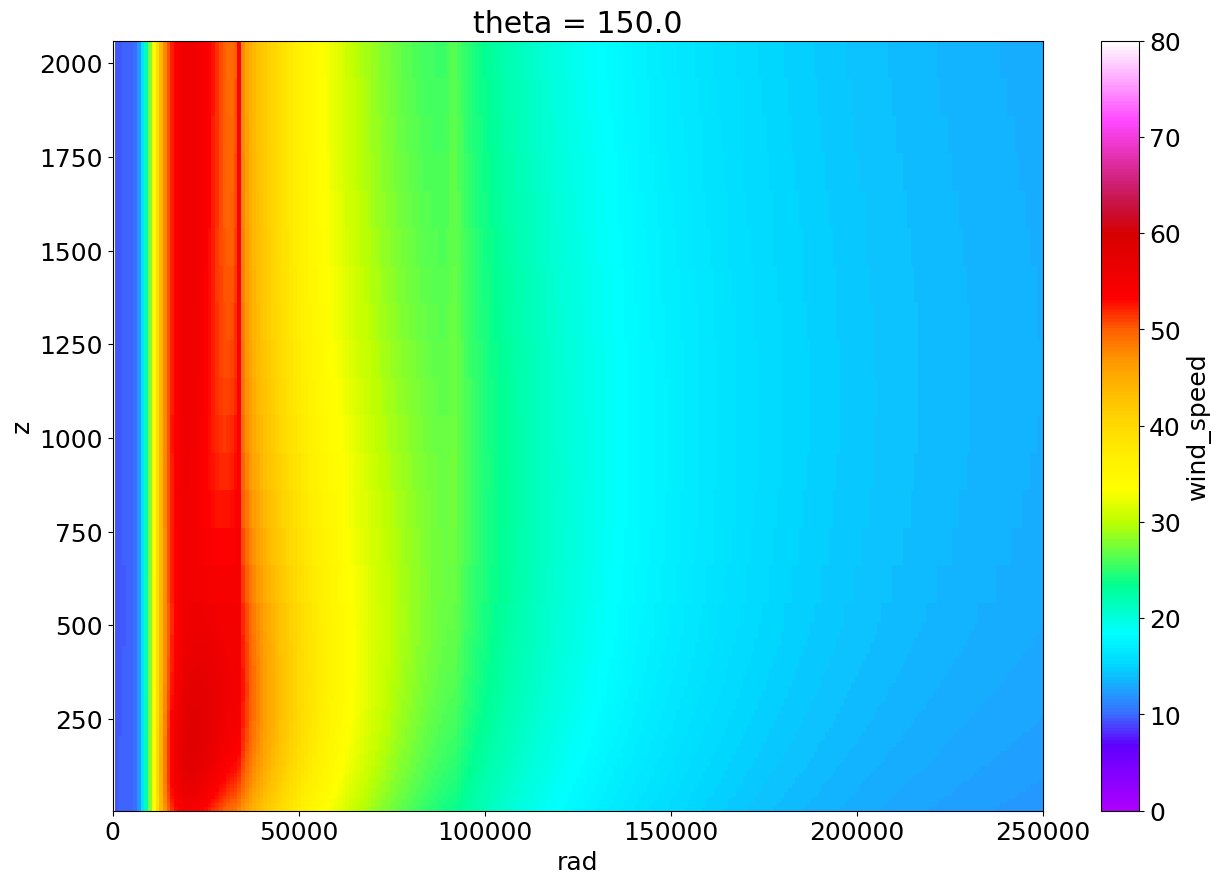

In [22]:
kep_pol1.sel(theta=150).wind_speed.plot(cmap=cwnd, norm=normalizer)
plt.xlim(0, 250000)

(0.0, 250000.0)

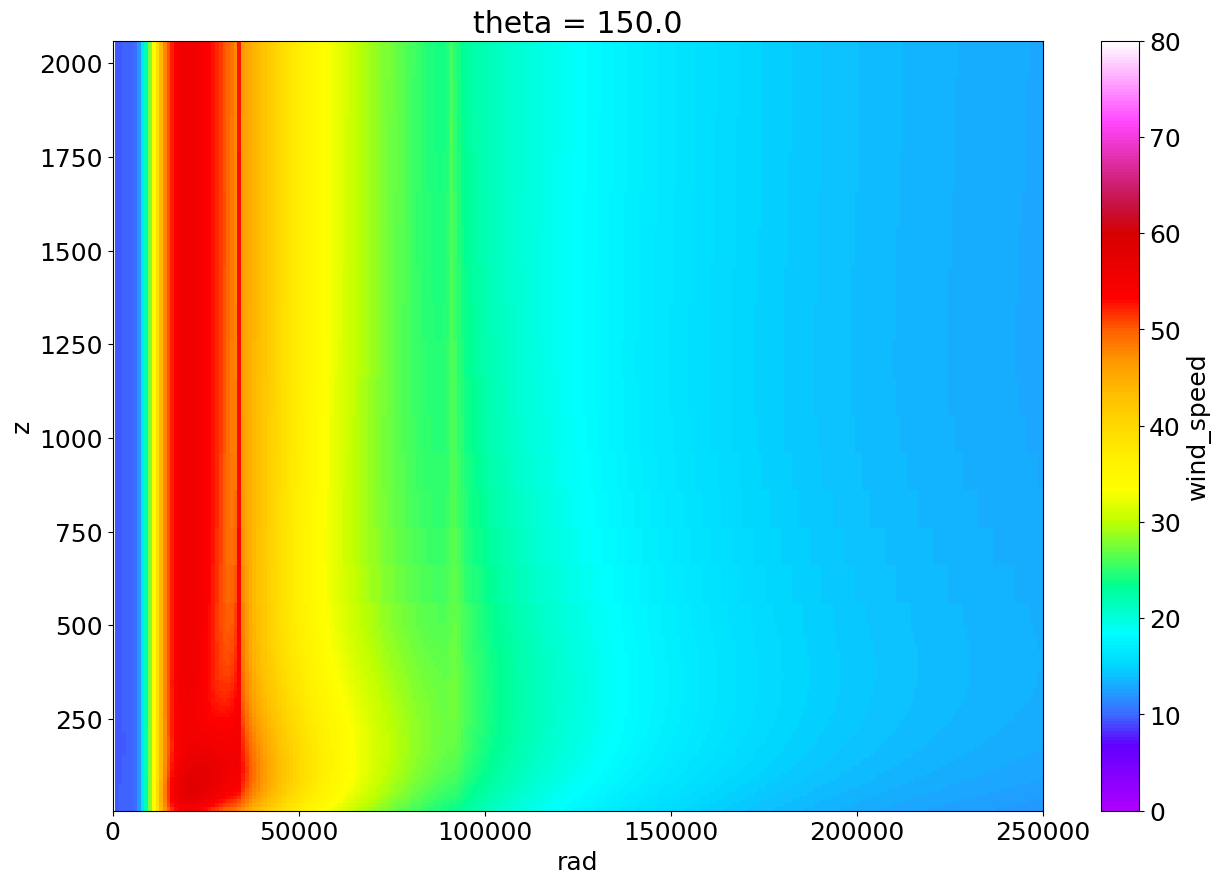

In [23]:
kep_pol2.sel(theta=150).wind_speed.plot(cmap=cwnd, norm=normalizer)
plt.xlim(0, 250000)

#### 6) Convert WIVERN to cylindrical coordinates

In [24]:
### ==> Convert to polar
# Create lon and lat grids
lons        = np.array(ds_wvn.lon)
lats        = np.array(ds_wvn.lat)
lons, lats  = np.meshgrid(lons, lats)

# Create center grids
lons_center = np.ones_like(lons) * lon_cen
lats_center = np.ones_like(lats) * lat_cen

# Compute azimuth and distance from center for each (lon, lat) pair
geod_wgs84        = CRS("epsg:4326").get_geod()
forward_az, _, dr = geod_wgs84.inv(lons_center, lats_center, lons, lats)
th                = get_polar_theta(forward_az) # r is dr

# Ref. grid
r_grd, t_grd = np.meshgrid(r_ref, t_ref)

# Interpolate on reference grid
ws_pol0      = griddata((dr.flatten() / 1000, th.flatten()), np.sqrt(np.array(ds_wvn.isel(dim_U__3=0).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3=0).V_ ** 2)).flatten(), (r_grd, t_grd), method='linear')
ws_pol1      = griddata((dr.flatten() / 1000, th.flatten()), np.sqrt(np.array(ds_wvn.isel(dim_U__3=1).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3=1).V_ ** 2)).flatten(), (r_grd, t_grd), method='linear')

# Create xr.Dataset
ds_pol = xr.Dataset(
    data_vars={
        'wind_speed':      (['z', 'theta', 'rad'], [ws_pol0, ws_pol1]),
        'lat_cen':         ([], lat_cen),
        'lon_cen':         ([], lon_cen),
    },
    coords={
        'z':     [1000, 2000],
        'theta': t_ref,
        'rad':   r_ref * 1000
    }
)

### ==> Convert to cartesian
ds_x, ds_y = pol2cart(dr, np.deg2rad(th))

# Ref. grid
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)

# Interpolate on reference grid
ws_car0       = griddata((ds_x.flatten(), ds_y.flatten()), np.sqrt(np.array(ds_wvn.isel(dim_U__3=0).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3=0).V_ ** 2)).flatten(), (x_ref, y_ref), method='nearest')
ws_car1       = griddata((ds_x.flatten(), ds_y.flatten()), np.sqrt(np.array(ds_wvn.isel(dim_U__3=1).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3=1).V_ ** 2)).flatten(), (x_ref, y_ref), method='nearest')

#  Create Dataset
ds_car = xr.Dataset(
    data_vars={
        'wind_speed':      (['z', 'x', 'y'], [ws_car0, ws_car1]), 
        'lat_cen':         ([], lat_cen),
        'lon_cen':         ([], lon_cen),
    },
    coords={
        'z':     [1000, 2000],
        'x': dim_ref,
        'y': dim_ref
    }
)

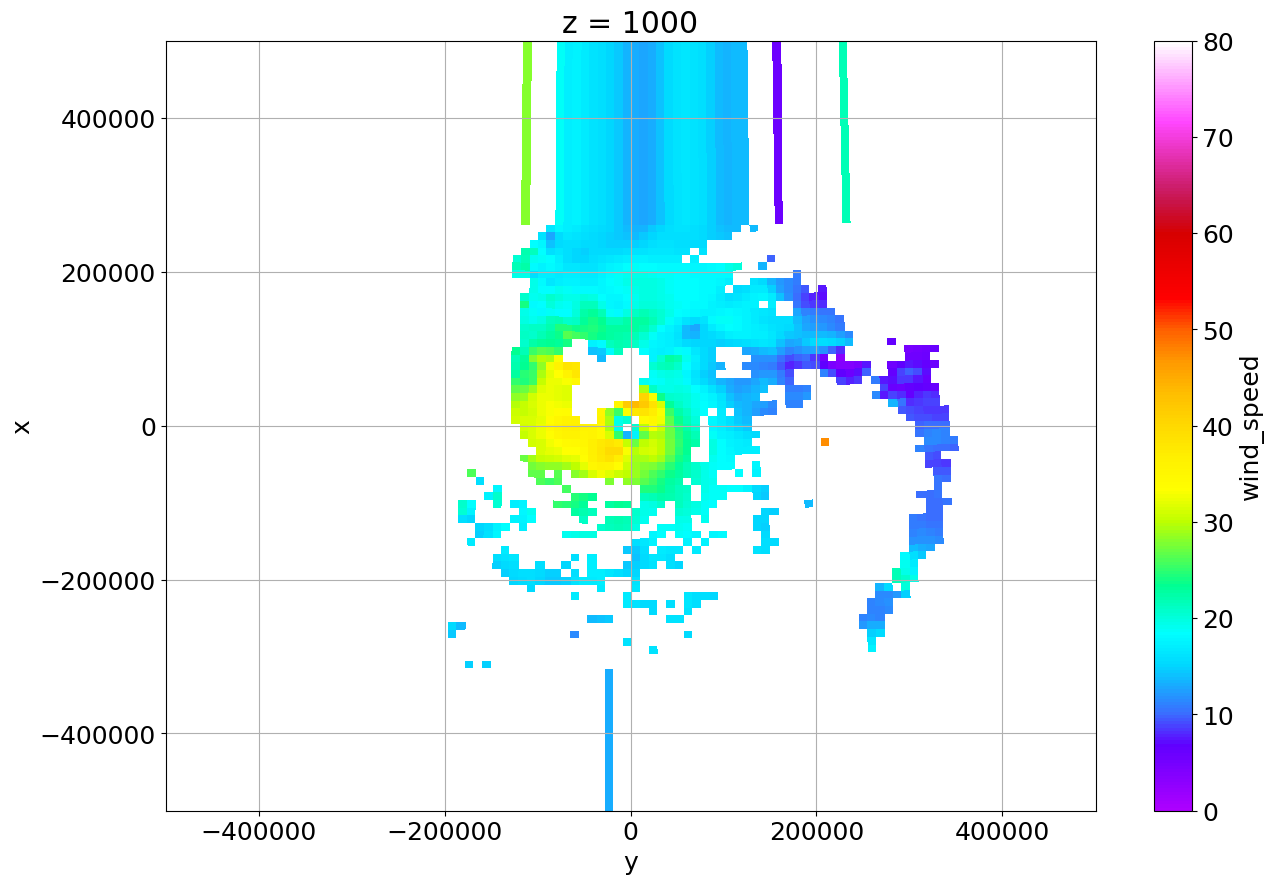

In [25]:
ds_car.sel(z=1000).wind_speed.plot(cmap=cwnd, norm=normalizer)
plt.grid()

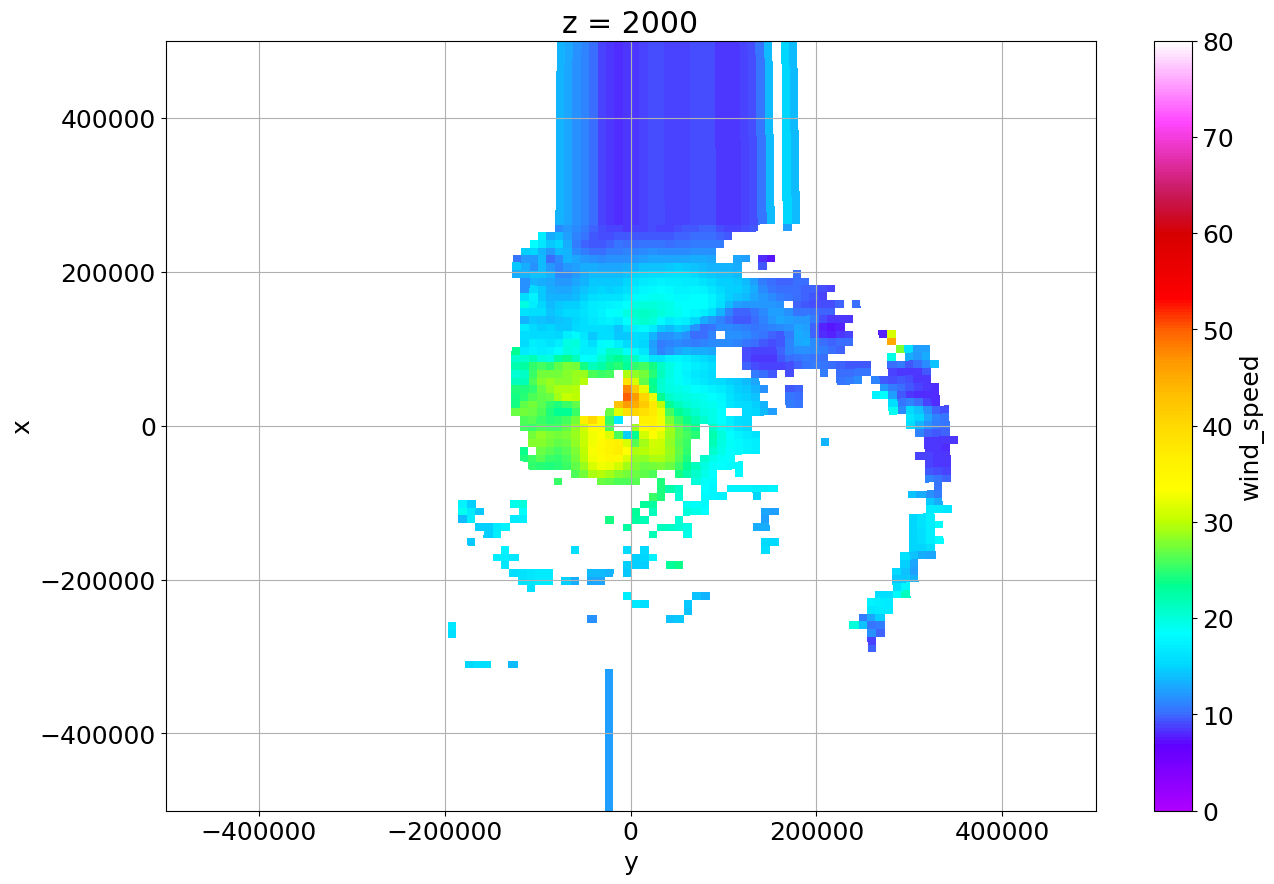

In [26]:
ds_car.sel(z=2000).wind_speed.plot(cmap=cwnd, norm=normalizer)
plt.grid()

In [27]:
wvn_lons, wvn_lats = np.meshgrid(ds_wvn.lon.isel(dim_lon_2=0), ds_wvn.lat.isel(dim_lat_2=0))

In [28]:
# z_level in km.
# .isel(z_level=0) ==> 1 km altitude; .isel(z_level=1) ==> 2 km altitude

lev = 0
plt.pcolormesh(wvn_lons, wvn_lats, np.sqrt(np.array(ds_wvn.isel(dim_U__3 = lev).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3 = lev).V_ ** 2)), cmap=cwnd, norm=normalizer)
plt.grid()
plt.colorbar(label='Wind speed (m/s)', orientation='vertical', pad=0.05, extend='neither')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

# plt.savefig(PTHS['sav_dir'] + 'ws_WVN_1km.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 1500x1000 with 0 Axes>

In [29]:
# z_level in km.
# .isel(z_level=0) ==> 1 km altitude; .isel(z_level=1) ==> 2 km altitude

lev = 1
plt.pcolormesh(wvn_lons, wvn_lats, np.sqrt(np.array(ds_wvn.isel(dim_U__3 = lev).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3 = lev).V_ ** 2)), cmap=cwnd, norm=normalizer)
plt.grid()
plt.colorbar(label='Wind speed (m/s)', orientation='vertical', pad=0.05, extend='neither')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')

# plt.savefig(PTHS['sav_dir'] + 'ws_WVN_2km.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 1500x1000 with 0 Axes>

#### 7) Try to calibrate boundary layer - polar

In [30]:
slc = slice(210, 270)
kep_pol1.sel(theta=slc).wind_speed.mean(dim='theta').plot(cmap=cwnd, norm=normalizer)
plt.scatter(ds_pol.rad, np.ones_like(ds_pol.rad) * 1000, c=ds_pol.sel(theta=slc).wind_speed.mean(dim='theta').sel(z=1000), cmap=cwnd, norm=normalizer, edgecolors='k')
plt.scatter(ds_pol.rad, np.ones_like(ds_pol.rad) * 2000, c=ds_pol.sel(theta=slc).wind_speed.mean(dim='theta').sel(z=2000), cmap=cwnd, norm=normalizer, edgecolors='k')
plt.xlim(0, 250000)
# plt.savefig(PTHS['sav_dir'] + 'ws_m1_azimuthalTransect.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 1500x1000 with 0 Axes>

In [31]:
slc = slice(210, 270)
kep_pol2.sel(theta=slc).wind_speed.mean(dim='theta').plot(cmap=cwnd, norm=normalizer)
plt.scatter(ds_pol.rad, np.ones_like(ds_pol.rad) * 1000, c=ds_pol.sel(theta=slc).wind_speed.mean(dim='theta').sel(z=1000), cmap=cwnd, norm=normalizer, edgecolors='k')
plt.scatter(ds_pol.rad, np.ones_like(ds_pol.rad) * 2000, c=ds_pol.sel(theta=slc).wind_speed.mean(dim='theta').sel(z=2000), cmap=cwnd, norm=normalizer, edgecolors='k')
plt.xlim(0, 250000)
# plt.savefig(PTHS['sav_dir'] + 'ws_m2_azimuthalTransect.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 1500x1000 with 0 Axes>

In [32]:
# slc = slice(0, 90)
# slc = slice(90, 150)
# slc = slice(150, 210)
slc = slice(210, 270) # Best?
# slc = slice(270, 330)

In [33]:
ds_pol.sel(theta=slc, z=1000).wind_speed.mean(dim='theta').plot(c='k', label='WIVERN')
ds_pol.sel(theta=slc, z=2000).wind_speed.mean(dim='theta').plot(c='k', label='WIVERN', linestyle='dashed')

kep_pol1.sel(theta=slc, z=1010).wind_speed.mean(dim='theta').plot(c='tab:blue', label='Model 1')
kep_pol1.sel(theta=slc, z=2010).wind_speed.mean(dim='theta').plot(c='tab:blue', label='Model 1', linestyle='dashed')

kep_pol2.sel(theta=slc, z=1010).wind_speed.mean(dim='theta').plot(c='tab:red',  label='Model 2')
kep_pol2.sel(theta=slc, z=2010).wind_speed.mean(dim='theta').plot(c='tab:red',  label='Model 2', linestyle='dashed')

plt.grid()
plt.legend(frameon=False)

# plt.savefig(PTHS['sav_dir'] + 'ws_azimuthalProfile.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 1500x1000 with 0 Axes>

In [34]:
# slc = slice(0, 90) # Bad
# slc = slice(90, 150)  # Ok
slc = slice(120, 180)
# slc = slice(150, 210)   # Ok
# slc = slice(170, 230) # Ok
# slc = slice(210, 270) # Ok
# slc = slice(270, 330) # Bad

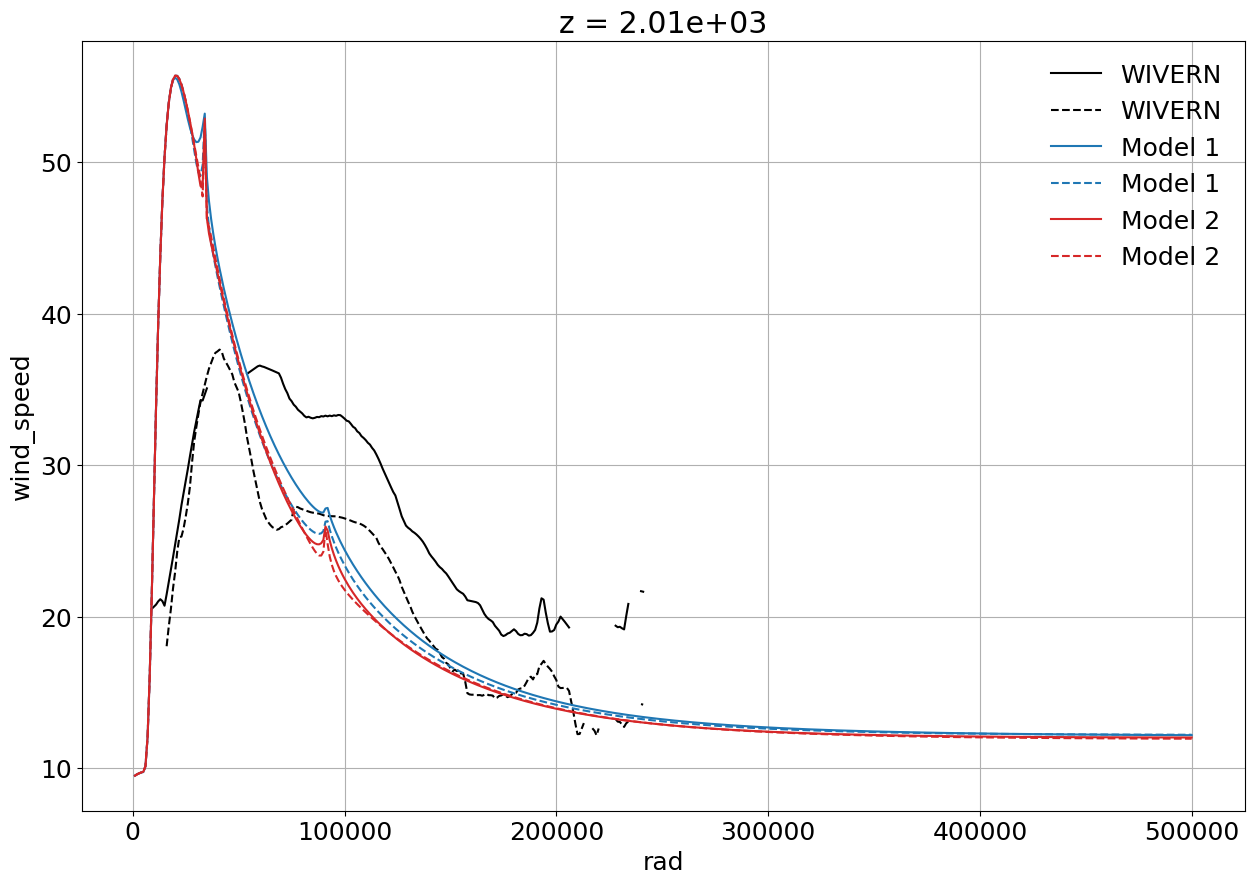

In [35]:
ds_pol.sel(theta=slc, z=1000).wind_speed.mean(dim='theta').plot(c='k', label='WIVERN')
ds_pol.sel(theta=slc, z=2000).wind_speed.mean(dim='theta').plot(c='k', label='WIVERN', linestyle='dashed')

kep_pol1.sel(theta=slc, z=1010).wind_speed.mean(dim='theta').plot(c='tab:blue', label='Model 1')
kep_pol1.sel(theta=slc, z=2010).wind_speed.mean(dim='theta').plot(c='tab:blue', label='Model 1', linestyle='dashed')

kep_pol2.sel(theta=slc, z=1010).wind_speed.mean(dim='theta').plot(c='tab:red',  label='Model 2')
kep_pol2.sel(theta=slc, z=2010).wind_speed.mean(dim='theta').plot(c='tab:red',  label='Model 2', linestyle='dashed')

plt.grid()
plt.legend(frameon=False)

#### 8) Try to calibrate boundary layer - cartesian

In [36]:
KEP_CARS1 = []
for z in tqdm([1010, 2010]): # Takes ~20 seconds
    kep_car1 = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol1.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol1.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol1.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol1.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    KEP_CARS1.append(kep_car1)
kep_car1 = xr.concat(KEP_CARS1, 'z').assign_coords({'z': [1010, 2010]})

KEP_CARS2 = []
for z in tqdm([1010, 2010]): # Takes ~20 seconds
    kep_car2 = xr.Dataset(
        data_vars={
            'wind_speed':   (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol2.sel(z=z).wind_speed).flatten(),   (x_ref, y_ref), method='nearest')),
            'rad_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol2.sel(z=z).rad_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'tan_wind':     (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol2.sel(z=z).tan_wind).flatten(),     (x_ref, y_ref), method='nearest')),
            'inflow_angle': (('x', 'y'), griddata((Xs[0, :, :].flatten(), Ys[0, :, :].flatten()), np.array(kep_pol2.sel(z=z).inflow_angle).flatten(), (x_ref, y_ref), method='nearest')),
        },
        coords={
            'x': dim_ref,
            'y': dim_ref,
        }
    )
    KEP_CARS2.append(kep_car2)
kep_car2 = xr.concat(KEP_CARS2, 'z').assign_coords({'z': [1010, 2010]})

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
kep_car1.sel(z=1010).wind_speed.plot(cmap=cwnd, norm=normalizer)
plt.scatter(ds_x, ds_y, c=np.sqrt(np.array(ds_wvn.isel(dim_U__3=0).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3=0).V_ ** 2)), s=20, cmap=cwnd, norm=normalizer, edgecolors='k')
# plt.savefig(PTHS['sav_dir'] + 'ws_1km_m1.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 1500x1000 with 0 Axes>

In [38]:
kep_car2.sel(z=1010).wind_speed.plot(cmap=cwnd, norm=normalizer)
plt.scatter(ds_x, ds_y, c=np.sqrt(np.array(ds_wvn.isel(dim_U__3=0).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3=0).V_ ** 2)), s=20, cmap=cwnd, norm=normalizer, edgecolors='k')
# plt.savefig(PTHS['sav_dir'] + 'ws_1km_m2.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 1500x1000 with 0 Axes>

In [39]:
kep_car1.sel(z=2010).wind_speed.plot(cmap=cwnd, norm=normalizer)
plt.scatter(ds_x, ds_y, c=np.sqrt(np.array(ds_wvn.isel(dim_U__3=1).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3=1).V_ ** 2)), s=20, cmap=cwnd, norm=normalizer, edgecolors='k')
# plt.savefig(PTHS['sav_dir'] + 'ws_2km_m1.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 1500x1000 with 0 Axes>

In [40]:
kep_car2.sel(z=2010).wind_speed.plot(cmap=cwnd, norm=normalizer)
plt.scatter(ds_x, ds_y, c=np.sqrt(np.array(ds_wvn.isel(dim_U__3=1).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3=1).V_ ** 2)), s=20, cmap=cwnd, norm=normalizer, edgecolors='k')
# plt.savefig(PTHS['sav_dir'] + 'ws_2km_m2.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 1500x1000 with 0 Axes>

In [41]:
### TODO: Interpolate kep_car wind speeds on WIVERN to compute RMSEs and show that model 2 is better.

In [42]:
# Improve interpolation (linear)
ws_car0       = griddata((ds_x.flatten(), ds_y.flatten()), np.sqrt(np.array(ds_wvn.isel(dim_U__3=0).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3=0).V_ ** 2)).flatten(), (x_ref, y_ref), method='linear')
ws_car1       = griddata((ds_x.flatten(), ds_y.flatten()), np.sqrt(np.array(ds_wvn.isel(dim_U__3=1).U_) ** 2 + np.array(ds_wvn.isel(dim_V__3=1).V_ ** 2)).flatten(), (x_ref, y_ref), method='linear')

#  Create Dataset
ds_car_lin = xr.Dataset(
    data_vars={
        'wind_speed':      (['z', 'x', 'y'], [ws_car0, ws_car1]), 
        'lat_cen':         ([], lat_cen),
        'lon_cen':         ([], lon_cen),
    },
    coords={
        'z':     [1000, 2000],
        'x': dim_ref,
        'y': dim_ref
    }
)

In [43]:
# Compute RMSEs
rmse1 = (rmse(kep_car1.sel(z=1010).wind_speed, ds_car_lin.sel(z=1000).wind_speed) + rmse(kep_car1.sel(z=2010).wind_speed, ds_car_lin.sel(z=2000).wind_speed)) / 2
rmse2 = (rmse(kep_car2.sel(z=1010).wind_speed, ds_car_lin.sel(z=1000).wind_speed) + rmse(kep_car2.sel(z=2010).wind_speed, ds_car_lin.sel(z=2000).wind_speed)) / 2
print('RMSE = {:.2f} m/s'.format(rmse1))
print('RMSE = {:.2f} m/s'.format(rmse2))

RMSE = 5.75 m/s
RMSE = 5.81 m/s


In [44]:
plt.plot(rs, delta0(Rs, Vs_try1, fixed_K, fcr)[0, 0, :], label='BL height, model 1')
plt.plot(rs, delta0(Rs, Vs_try2, fixed_K / 9, fcr)[0, 0, :], label='BL height, model 2')
# plt.plot(rs, delta0(Rs, Vs_try2, fixed_K * 4, fcr)[0, 0, :])
plt.xlabel('Distance from TC center (m)')
plt.ylabel('Height (m)')
plt.legend(frameon=False)
plt.grid()

# plt.savefig(PTHS['sav_dir'] + 'BL_heights.png', bbox_inches='tight', format='png');plt.clf()

<Figure size 1500x1000 with 0 Axes>